# Drought Prediction in the Mediterranean

In [12]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer, Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, plot_confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from collections import Counter
%matplotlib inline
import numpy as np
import pandas as pd
import pickle

In [6]:
# # Train/Test Split - Just run once
# X_tas = np.load('Data/tas_train.npy')
# X_psl = np.load('Data/psl_train.npy')
# y=np.load('Data/nao_index_train.npy')

# X = np.concatenate((X_tas, X_psl),axis=1)
# y=y.reshape(-1,1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# np.save('Data/train/X_train.npy', X_train)
# np.save('Data/test/X_test.npy', X_test)
# np.save('Data/train/y_train.npy', y_train)
# np.save('Data/test/y_test.npy', y_test)

# Exploratory Data Analysis

In [13]:
#Load training data
X_train = np.load('Data/train/X_train.npy')
y_train = np.load('Data/train/y_train.npy')
print(X_train.shape)
print(y_train.shape)

(720, 4644)
(720, 1)


In [3]:
# Data are standardized by column
X_df = pd.DataFrame(X_train)
print("Range of means: ",X_df.mean().max() - X_df.mean().min())
print("Range of stdevs: ",X_df.std().max() - X_df.std().min())

Range of means:  0.10698490791697654
Range of stdevs:  0.09475504033032955


In [4]:
# No missing data (synthetic dataset, so none are expected)
X_df.isna().sum().sum()

0

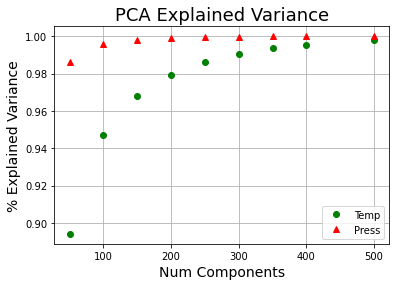

In [42]:
# PCA - Virtually all variance is explained in the first 200 PCs of press and the first 500 PCs of temp
num_components = [50,100,150,200,250,300,350,400,500]
explained_variance_temp = []
explained_variance_press = []
for i in num_components:
    pca_temp = PCA(n_components=i)
    pca_press = PCA(n_components=i)
    X_tas_pca = pca_temp.fit_transform(X_train[:,0:2322])
    X_psl_pca = pca_press.fit_transform(X_train[:,2322:4645])
    explained_variance_temp.append(pca_temp.explained_variance_ratio_.sum())
    explained_variance_press.append(pca_press.explained_variance_ratio_.sum())

    
plt.plot(num_components,explained_variance_temp,'go',label="Temp")
plt.plot(num_components,explained_variance_press,"r^",label="Press")
plt.title("PCA Explained Variance", fontsize=18)
plt.xlabel("Num Components",fontsize=14)
plt.ylabel("% Explained Variance", fontsize=14)
plt.legend(loc="lower right")
plt.grid()
plt.show()


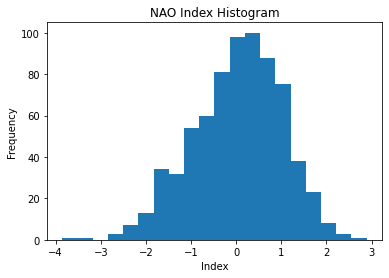

In [6]:
np.histogram(y_train, bins=20);
plt.title("NAO Index Histogram")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.hist(y_train,bins=20)
plt.show()

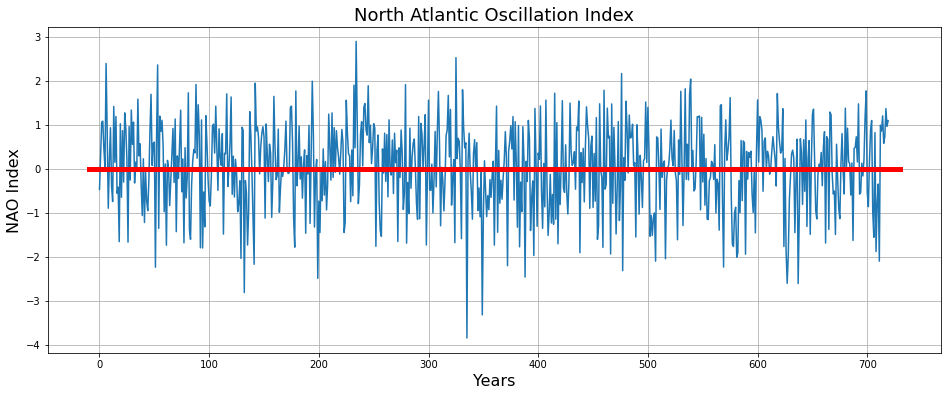

In [34]:
x = list(range(0,len(y_train)))
plt.figure(figsize=(16,6))
plt.plot(x,y_train,'-')
plt.plot([-10, 730], [0,0], 'r-',lw=5)
plt.xlabel('Years',fontsize=16)
plt.ylabel('NAO Index',fontsize=16)
plt.title('North Atlantic Oscillation Index', fontsize=18)
plt.grid()
plt.show()

## Investigate Time Dependence

In [28]:
y_train_series = pd.Series(y_train.reshape((720,)))
autoc = []
for i in range(-25,26):
    autoc.append(y_train_series.autocorr(lag=i))
    

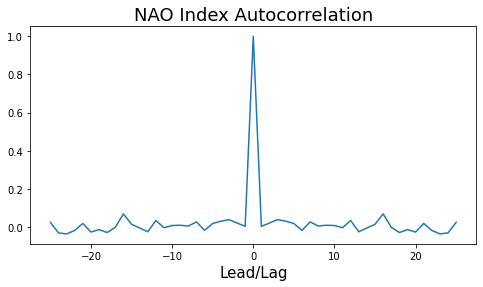

In [41]:
plt.figure(figsize=(8,4))
plt.plot(list(range(-25,26)),autoc)
plt.title('NAO Index Autocorrelation', fontsize=18)
plt.xlabel('Lead/Lag', fontsize=15)
plt.show()

### Investigate Correlation between target variable and each coordinate

In [7]:
data = pd.DataFrame(X_train)

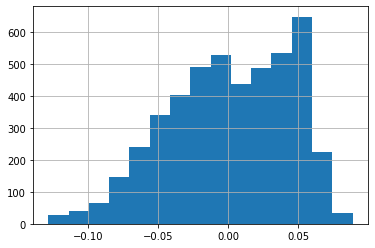

In [8]:
data.corrwith(pd.Series(y_train.reshape(720,))).hist(bins=15);

# Preprocessing

In [14]:
# Transform Training Data with PCA
pca_temp = PCA(n_components=500)
pca_press = PCA(n_components=200)
# After feedback from Eduardo Zorita, reduced the number of PCs.
# pca_temp = PCA(n_components=15)
# pca_press = PCA(n_components=15)

X_tas_pca = pca_temp.fit_transform(X_train[:,0:2322])
X_psl_pca = pca_press.fit_transform(X_train[:,2322:4645])
X_train_pca = np.concatenate((X_tas_pca,X_psl_pca),axis=1)

In [15]:
# Calculate reconstruction error
X_tas_projected = pca_temp.inverse_transform(X_tas_pca)
X_psl_projected = pca_press.inverse_transform(X_psl_pca)
loss_temp = ((X_train[:,0:2322]-X_tas_projected)**2).mean()
loss_press = ((X_train[:,2322:4645]-X_psl_projected)**2).mean()
print('MSE Temp: '+str(loss_temp))
print('MSE Press: '+str(loss_press))

MSE Temp: 0.001921133342502432
MSE Press: 0.0009239558946874844


In [16]:
# Convert target to binary
y_train_bin = np.sign(y_train).reshape(-1,)


# Random Forest Classifier
## Binary Classification (positive or negative NAOI)

In [52]:
rf = RandomForestClassifier(random_state=1337)

In [10]:
# HPO without PCA
## Random Forest ##
parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
clf = GridSearchCV(rf, parameters,scoring='f1')
clf.fit(X_train,y_train_bin)
print(clf.best_score_)
print(clf.best_params_)

0.6518982229762063
{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}


Best F1 Score: 0.6518982229762063

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}

In [11]:
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.758310,0.127190,0.013613,0.001219,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.666667,0.583784,0.683938,0.630435,0.617801,0.636525,0.035569,3
1,2.740571,0.119680,0.012509,0.000422,entropy,10,15,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.606383,0.604396,0.666667,0.622951,0.652406,0.630560,0.024932,6
2,2.908190,0.036275,0.011998,0.000249,entropy,100,5,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.612022,0.585635,0.666667,0.605405,0.639175,0.621781,0.028239,7
3,2.770911,0.042325,0.012379,0.000459,entropy,100,15,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.613757,0.607735,0.694737,0.633880,0.630435,0.636109,0.030916,4
4,1.528268,0.035313,0.013874,0.001547,gini,10,5,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.620321,0.642487,0.713568,0.623656,0.659459,0.651898,0.033893,1
5,1.492679,0.032881,0.012194,0.000387,gini,10,15,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.627660,0.595745,0.634921,0.645161,0.652632,0.631224,0.019686,5
6,1.702611,0.038729,0.013588,0.001336,gini,100,5,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.608696,0.652632,0.670157,0.602273,0.688172,0.644386,0.033754,2
7,1.674827,0.069773,0.012906,0.000868,gini,100,15,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.627027,0.568306,0.673575,0.595506,0.641304,0.621144,0.036440,8


In [53]:
# HPO with PCA
## Random Forest ##
parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
clf = GridSearchCV(rf, parameters,scoring='f1')
clf.fit(X_train_pca,y_train_bin)
print(clf.best_score_)
print(clf.best_params_)

0.6833816231947019
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 15}


Best F1 Score: 0.6833816231947019

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 15}

In [54]:
# Better performance when using PCA transform
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.009823,0.094017,0.012163,0.005440,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.656410,0.666667,0.656863,0.646154,0.635897,0.652398,0.010497,8
1,0.992177,0.065954,0.009441,0.000766,entropy,10,15,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.683673,0.682692,0.676329,0.666667,0.707547,0.683382,0.013518,1
2,1.082008,0.059307,0.009326,0.001536,entropy,100,5,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.666667,0.624390,0.676471,0.659794,0.645833,0.654631,0.018113,7
3,1.051135,0.011253,0.009556,0.000766,entropy,100,15,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.670103,0.682927,0.650246,0.649485,0.683168,0.667186,0.014913,4
4,0.625771,0.028428,0.009856,0.000668,gini,10,5,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.649746,0.701422,0.663415,0.708738,0.672986,0.679261,0.022457,2
5,0.576283,0.009955,0.009427,0.000516,gini,10,15,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.653659,0.689320,0.689320,0.679803,0.673077,0.677036,0.013203,3
6,0.646983,0.021746,0.011645,0.002109,gini,100,5,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.673469,0.653465,0.669903,0.702970,0.633663,0.666694,0.022970,5
7,0.634150,0.017598,0.009919,0.000077,gini,100,15,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.660000,0.712871,0.647343,0.656863,0.640394,0.663494,0.025647,6


In [55]:
# Persist RF wPCA Model
with open('Data/RF_Bin_wPCA', 'wb') as f:
    pickle.dump(clf, f)

## Testing

In [17]:
# Load Test Data
X_test = np.load('Data/test/X_test.npy')
y_test = np.load('Data/test/y_test.npy')

In [18]:
#transform test data
X_tas_pca_test = pca_temp.transform(X_test[:,0:2322])
X_psl_pca_test = pca_press.transform(X_test[:,2322:4645])
X_test_pca = np.concatenate((X_tas_pca_test,X_psl_pca_test),axis=1)
y_test_bin = np.sign(y_test)


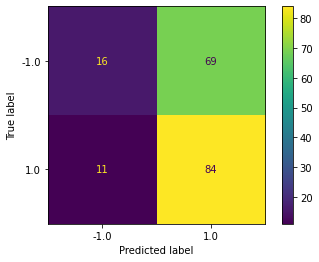

In [58]:
plot_confusion_matrix(clf, X_test_pca, y_test_bin)

In [59]:
y_pred = clf.predict(X_test_pca)

In [60]:
print('F1 score: '+str(f1_score(y_test_bin, y_pred, average='binary')))

F1 score: 0.6774193548387097


In [61]:
np.unique(y_test_bin, return_counts=True)

(array([-1.,  1.]), array([85, 95], dtype=int64))

# XGBoost

In [19]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [20]:
y_train_bin_xg = Binarizer().fit_transform(y_train)
y_test_bin_xg = Binarizer().fit_transform(y_test)
dtrain = xgb.DMatrix(X_train_pca, label=y_train_bin_xg)
dtest = xgb.DMatrix(X_test_pca, label=y_test_bin_xg)

In [46]:
param = {'alpha':15, 'gamma':0.1, 'eta':0.1, 'objective': 'binary:logistic','max_depth':3, 'subsample':0.8, 'min_child_weight':5, 'eval_metric':'auc'}
# param['eval_metric'] = 'error'
# evallist = [(dtest,'eval'),(dtrain,'train')]
num_round = 55

In [47]:
# bst = xgb.train(param, dtrain, num_round, evallist)
bst = xgb.train(param, dtrain, num_round)

In [39]:
# AUC used as metric as F1 isn't offered natively in XGB.
params = {'alpha':15, 'gamma':0.1, 'eta':0.1, 'objective': 'binary:logistic','max_depth':3, 'subsample':0.5, 'min_child_weight':5}
cvresult = xgb.cv(params, dtrain, nfold=5, metrics='auc', num_boost_round=500, early_stopping_rounds=50)

In [40]:
cvresult

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.593139,0.019480,0.488580,0.021847
1,0.643263,0.019185,0.509482,0.021299
2,0.688701,0.013790,0.516396,0.018255
3,0.721121,0.011999,0.510563,0.016448
4,0.743961,0.011994,0.523194,0.022942
5,0.764917,0.015503,0.509740,0.030041
6,0.781019,0.014837,0.516672,0.038552
7,0.790437,0.016908,0.496915,0.029074
8,0.800662,0.013034,0.512029,0.025942
9,0.815513,0.014777,0.515883,0.030399


In [162]:
# HPO - optimized parameters in this order: min_child_weight/max_depth, gamma, subsample, regularization
# parameters = {'reg_alpha':(1,5,15,50)}
# clf = GridSearchCV(XGBClassifier(gamma=0.1, max_depth=3, min_child_weight=5, eta=0.1, subsample=0.8, objective='binary:logistic',n_estimators=55), parameters,scoring='f1')
# clf.fit(X_train_pca, y_train_bin_xg.reshape(720,))
# print(clf.best_score_)
# print(clf.best_params_)

0.6538350311262027
{'reg_alpha': 15}


In [48]:
train_pred = bst.predict(xgb.DMatrix(X_train_pca))
train_pred_bin = train_pred>=0.5
print('Training F1 score: '+str(f1_score(y_train_bin_xg, train_pred_bin, average='binary')))

Training F1 score: 0.9239766081871346


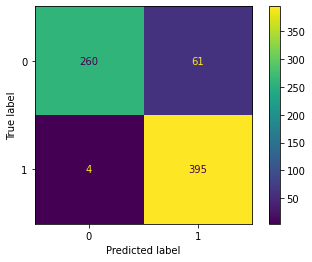

In [49]:
ConfusionMatrixDisplay(confusion_matrix(y_train_bin_xg, train_pred_bin)).plot()

In [50]:
y_pred = bst.predict(xgb.DMatrix(X_test_pca))
y_pred_bin = y_pred>=0.5

In [51]:
print('Test F1 score: '+str(f1_score(y_test_bin_xg, y_pred_bin, average='binary')))

Test F1 score: 0.6779661016949153


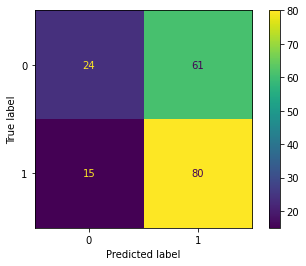

In [52]:
ConfusionMatrixDisplay(confusion_matrix(y_test_bin_xg, y_pred_bin)).plot()

In [175]:
# dump model
bst.dump_model('Data/xgboost_model.txt')

# SVC

In [53]:
from sklearn.svm import SVC

In [60]:
svc_clf = SVC(kernel='sigmoid', gamma='auto', C=10)

In [61]:
svc_clf.fit(X_train_pca, y_train_bin)

SVC(C=10, gamma='auto', kernel='sigmoid')

In [62]:
svc_clf.score(X_test_pca, y_test_bin)

0.5

# Autoencoder - Not Used in Final Model

In [14]:
import keras
from keras import layers
from keras.optimizers import Adam

In [19]:
# Simplest Autoencoder 
# encoding_dim = 255
# input_img = keras.Input(shape=(43,54,))
# encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# decoded = layers.Dense(2322, activation='sigmoid')(encoded)
# autoencoder = keras.Model(input_img, decoded)
# encoder = keras.Model(input_img, encoded)
# encoded_input = keras.Input(shape=(encoding_dim,))
# decoder_layer = autoencoder.layers[-1]
# decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
# customAdam = Adam(lr=0.001)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [40]:
# Convolutional Encoder
input_img = keras.Input(shape=(43,54,1))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
print(x.shape)
x = layers.ZeroPadding2D(padding=((0,5),(0,2)))(x)
print(x.shape)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
print('encoded',encoded.shape)

# at this point the representation is (6,7,8) i.e. 336-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Cropping2D(cropping=((0,5),(0,2)))(x)
print('Cropped',x.shape)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded.shape)

(None, 43, 54, 16)
(None, 48, 56, 16)
(None, 24, 28, 16)
(None, 24, 28, 8)
(None, 12, 14, 8)
(None, 12, 14, 8)
encoded (None, 6, 7, 8)
(None, 6, 7, 8)
(None, 12, 14, 8)
(None, 12, 14, 8)
(None, 24, 28, 8)
(None, 24, 28, 16)
(None, 48, 56, 16)
Cropped (None, 43, 54, 16)
(None, 43, 54, 1)


In [43]:
# Simpler CNN Autoencoder
# input_img = keras.Input(shape=(43,54,1))
# x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
# print(x.shape)
# x = layers.ZeroPadding2D(padding=((0,5),(0,2)))(x)
# print(x.shape)
# encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
# print('encoded',encoded.shape)

# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# print(x.shape)
# x = layers.UpSampling2D((2, 2))(x)
# print(x.shape)
# x = layers.Cropping2D(cropping=((0,5),(0,2)))(x)
# print('Cropped',x.shape)
# decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# print(decoded.shape)

(None, 43, 54, 16)
(None, 48, 56, 16)
encoded (None, 24, 28, 16)
(None, 24, 28, 8)
(None, 48, 56, 8)
Cropped (None, 43, 54, 8)
(None, 43, 54, 1)


In [44]:
autoencoder = keras.Model(input_img, decoded)
opt = Adam(learning_rate=0.03)
autoencoder.compile(optimizer=opt, loss=keras.losses.MeanSquaredError())

## Preprocessing

In [27]:
# For convolutional autoencoder
X_train_temp_auto = X_train[:,0:2322].reshape((720,43,54))
X_train_press_auto = X_train[:,2322:4645].reshape((720,43,54))
X_test_temp_auto = X_test[:,0:2322].reshape((180,43,54))
X_test_press_auto = X_test[:,2322:4645].reshape((180,43,54))

## Train the Autoencoder

In [45]:
autoencoder.fit(X_train_press_auto, X_train_press_auto, epochs=200, batch_size=25, shuffle=False, validation_data=(X_test_press_auto, X_test_press_auto))

Epoch 1/200
29/29 [==============================] - 1s 45ms/step - loss: 0.6978 - val_loss: 0.6237
Epoch 2/200
29/29 [==============================] - 1s 43ms/step - loss: 0.6205 - val_loss: 0.6028
Epoch 3/200
29/29 [==============================] - 1s 43ms/step - loss: 0.6060 - val_loss: 0.5919
Epoch 4/200
29/29 [==============================] - 1s 43ms/step - loss: 0.5997 - val_loss: 0.5884
Epoch 5/200
29/29 [==============================] - 1s 44ms/step - loss: 0.5972 - val_loss: 0.5852
Epoch 6/200
29/29 [==============================] - 1s 45ms/step - loss: 0.5950 - val_loss: 0.5839
Epoch 7/200
29/29 [==============================] - 1s 46ms/step - loss: 0.5947 - val_loss: 0.5830
Epoch 8/200
29/29 [==============================] - 1s 46ms/step - loss: 0.5925 - val_loss: 0.5823
Epoch 9/200
29/29 [==============================] - 1s 48ms/step - loss: 0.5923 - val_loss: 0.5811
Epoch 10/200
29/29 [==============================] - 1s 48ms/step - loss: 0.5918 - val_loss: 0.5818

KeyboardInterrupt: 

In [39]:
X_train_autoencoder = autoencoder.predict(X_train_temp_auto)
mse = ((X_train_temp_auto-X_train_autoencoder.reshape((720,43,54)))**2).mean()
print(mse)


0.588537791137136


#### This MSE is far worse than that of the PCA transform

# Other Failed Models

## Try out Autokeras

In [8]:
import autokeras as ak
import os

### StructuredDataClassifier

In [80]:
clf = ak.StructuredDataClassifier(
    overwrite=True,
    max_trials=2,
    directory=os.path.normpath('C:/')
)



In [81]:
# Feed the structured data classifier with training data.
clf.fit(X_train, y_train_bin, epochs=10)

Trial 2 Complete [00h 01m 23s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 02m 47s
INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Pyt

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

Epoch 1/10
See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lu

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

23/23 [==============================] - 0s 19ms/step - loss: -29.1473 - accuracy: 0.0000e+00
Epoch 2/10
23/23 [==============================] - 0s 20ms/step - loss: -158.3338 - accuracy: 0.0000e+00
Epoch 3/10
23/23 [==============================] - 0s 19ms/step - loss: -460.1530 - accuracy: 0.0000e+00
Epoch 4/10
23/23 [==============================] - 0s 21ms/step - loss: -1074.3298 - accuracy: 0.0000e+00
Epoch 5/10
23/23 [==============================] - 1s 26ms/step - loss: -2196.4949 - accuracy: 0.0000e+00
Epoch 6/10
23/23 [==============================] - 1s 29ms/step - loss: -4055.3350 - accuracy: 0.0000e+00
Epoch 7/10
23/23 [==============================] - 1s 29ms/step - loss: -6880.6533 - accuracy: 0.0000e+00
Epoch 8/10
23/23 [==============================] - 1s 29ms/step - loss: -10867.9248 - accuracy: 0.0000e+00
Epoch 9/10
23/23 [==============================] - 1s 34ms/step - loss: -16202.3682 - accuracy: 0.0000e+00
Epoch 10/10
23/23 [==============================]

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

INFO:tensorflow:Assets written to: C:\structured_data_classifier\best_model\assets


In [83]:
predicted_y = clf.predict(X_test)
print(clf.evaluate(X_test, y_test))

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/common_errors.md#warning-large-unrolled-loop-detected
Location:
  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)

  File "C:\Users\Lucas\AppData\Local\Programs\Python\Python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()

  File "C:\Users\Lucas\.virtualenvs\UT\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()

  File "C:\Users\Lucas\AppData

6/6 [==============================] - 0s 29ms/step - loss: -26146.1504 - accuracy: 0.0000e+00
[-26146.150390625, 0.0]
